In [68]:
import pandas as pd
import scipy
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import metrics
import numpy as np


In [2]:
df = pd.read_csv('Crime_Data_from_2010_to_Present.csv')

In [3]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [4]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [5]:
#drop columns irrelevant to our data analysis
drop_cols = [
    'DR_NO',
    'Date Rptd',
    'AREA ',
    'Rpt Dist No',
    'Part 1-2',
    'Crm Cd',
    'Premis Cd',
    'Premis Desc',
    'Weapon Used Cd',
    'Weapon Desc',
    'Mocodes',
    'Status',
    'Status Desc',
    'Crm Cd 1',
    'Crm Cd 2',
    'Crm Cd 3',
    'Crm Cd 4',
    'Cross Street',
    'LOCATION',
]

df = df.drop(drop_cols, axis=1)
df.columns

Index(['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'Vict Age',
       'Vict Sex', 'Vict Descent', 'LAT', 'LON'],
      dtype='object')

In [6]:
df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,02/20/2010 12:00:00 AM,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695
1,09/12/2010 12:00:00 AM,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
2,08/09/2010 12:00:00 AM,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
3,01/05/2010 12:00:00 AM,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295
4,01/02/2010 12:00:00 AM,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488


In [6]:
# clean up date occurred to only contain month/day/year
temp = df['DATE OCC'].str.split(' ',n = 1, expand = True)
temp2 = temp[0]
df['DATE OCC'] = temp2

In [7]:
df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,02/20/2010,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695
1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
3,01/05/2010,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295
4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488


In [9]:
df['Crm Cd Desc'].unique()

array(['VIOLATION OF COURT ORDER',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'OTHER MISCELLANEOUS CRIME', 'RAPE, ATTEMPTED',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'BURGLARY FROM VEHICLE',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BATTERY - SIMPLE ASSAULT', 'ROBBERY', 'BOMB SCARE',
       'CHILD NEGLECT (SEE 300 W.I.C.)',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'ATTEMPTED ROBBERY',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'BURGLARY', 'ARSON',
       'RAPE, FORCIBLE', 'BRANDISH WEAPON',
       'THROWING OBJECT AT MOVING VEHICLE',
       'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
       'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
       'SHOTS FIRED AT INHABITED DWELLING',
       'THEFT FROM MOTOR

In [11]:
#merging latitude and longitude into new column `COORDS`

# df['COORDS'] = list(zip(df['LAT'],df['LON']))
# df.drop(columns = ['LAT','LON'], axis = 1, inplace = True)

In [8]:
df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,02/20/2010,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695
1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
3,01/05/2010,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295
4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488


In [13]:
df['AREA NAME'].unique()

array(['Newton', 'Pacific', 'Hollywood', 'Central', 'Northeast',
       'Hollenbeck', 'Southwest', 'Southeast', 'Rampart', 'Olympic',
       'Wilshire', '77th Street', 'Harbor', 'West LA', 'Van Nuys',
       'West Valley', 'Topanga', 'N Hollywood', 'Mission', 'Foothill',
       'Devonshire'], dtype=object)

In [9]:
#drop all victimless crime
df.dropna(inplace = True)
df.reset_index(inplace = True)

In [25]:
#non-violent crimes list
non_violent = ['ABORTION/ILLEGAL',
    'BIGAMY',
    'BIKE - ATTEMPTED STOLEN',
    'BIKE - STOLEN',
    'BLOCKING DOOR INDUCTION CENTER',
    'BOAT - STOLEN',
    'BRIBERY',
    'BUNCO, ATTEMPT',
    'BUNCO, GRAND THEFT',
    'BUNCO, PETTY THEFT',
    'BURGLARY',
    'BURGLARY FROM VEHICLE',
    'BURGLARY FROM VEHICLE, ATTEMPTED',
    'BURGLARY, ATTEMPTED',
    'CHILD ABANDONMENT',
    'CHILD ANNOYING (17YRS & UNDER)',
    'CHILD NEGLECT (SEE 300 W.I.C.)',
    'CHILD PORNOGRAPHY',
    'CONSPIRACY',
    'CONTEMPT OF COURT',
    'CONTRIBUTING',
    'COUNTERFEIT',
    'CREDIT CARDS, FRAUD USE ($950 & UNDER',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
    'DISHONEST EMPLOYEE - GRAND THEFT',
    'DISHONEST EMPLOYEE - PETTY THEFT',
    'DISHONEST EMPLOYEE ATTEMPTED THEFT',
    'DISRUPT SCHOOL',
    'DISTURBING THE PEACE',
    'DOCUMENT FORGERY / STOLEN FELONY',
    'DOCUMENT WORTHLESS ($200 & UNDER)',
    'DOCUMENT WORTHLESS ($200.01 & OVER)',
    'DRIVING WITHOUT OWNER CONSENT (DWOC)',
    'DRUGS, TO A MINOR',
    'DRUNK ROLL',
    'DRUNK ROLL - ATTEMPT',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
    'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
    'EXTORTION',
    'FAILURE TO DISPERSE',
    'FAILURE TO YIELD',
    'FALSE IMPRISONMENT',
    'FALSE POLICE REPORT',
    'FIREARMS RESTRAINING ORDER (FIREARMS RO)',
    'FIREARMS TEMPORARY RESTRAINING ORDER (TEMP FIREARMS RO)',
    'GRAND THEFT / AUTO REPAIR',
    'GRAND THEFT / INSURANCE FRAUD',
    'ILLEGAL DUMPING',
    'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
    'INDECENT EXPOSURE',
    'LETTERS, LEWD - TELEPHONE CALLS, LEWD',
    'OTHER MISCELLANEOUS CRIME',
    'PANDERING',
    'PEEPING TOM',
    'PETTY THEFT - AUTO REPAIR',
    'PICKPOCKET',
    'PICKPOCKET, ATTEMPT',
    'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
    'SHOPLIFTING - ATTEMPT',
    'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
    'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
    'THEFT FROM MOTOR VEHICLE - ATTEMPT',
    'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
    'THEFT OF IDENTITY',
    'THEFT PLAIN - ATTEMPT',
    'THEFT PLAIN - PETTY ($950 & UNDER)',
    'THEFT, COIN MACHINE - ATTEMPT',
    'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
    'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
    'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL',
    'TILL TAP - ATTEMPT',
    'TILL TAP - GRAND THEFT ($950.01 & OVER)',
    'TILL TAP - PETTY ($950 & UNDER)',
    'TRESPASSING',
    'UNAUTHORIZED COMPUTER ACCESS',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
    'VEHICLE - ATTEMPT STOLEN',
    'VEHICLE - STOLEN',
    'VIOLATION OF COURT ORDER',
    'VIOLATION OF RESTRAINING ORDER',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER',
]


In [26]:
#create new column of violent and non-violent crimes
violent_crime = []

for index in range(len(df['Crm Cd Desc'])):
    if df['Crm Cd Desc'][index] in non_violent:
        violent_crime.append(0)
    else:
        violent_crime.append(1)

In [28]:
df['violent_crime'] = violent_crime
df.head()

,index,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON,Year,violent_crime
0,0,02/20/2010,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695,2010,0
1,1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962,2010,0
2,2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524,2010,0
3,3,01/05/2010,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295,2010,0
4,4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488,2010,1


In [46]:
#get max and min longitude
print('The max and min longitude values are ' + str(np.max(df['LON'])) + ' & ' + str(np.min(df['LON'])))
#get max and min latitude
print('The max and min latitude values are ' + str(np.max(df['LAT'])) + ' & ' + str(np.min(df['LAT'])))
#plot LAT v LON to visualize where crimes occur in LA


The max and min longitude values are -117.6596 & -118.8279
The max and min latitude values are 34.7907 & 33.3427


In [45]:
#drop all rows where lat or longitude = 0

df = df[df['LAT'] != 0]


In [47]:
#get max and min longitude
print('The max and min longitude values are ' + str(np.max(df['LON'])) + ' & ' + str(np.min(df['LON'])))
#get max and min latitude
print('The max and min latitude values are ' + str(np.max(df['LAT'])) + ' & ' + str(np.min(df['LAT'])))
#plot LAT v LON to visualize where crimes occur in LA


The max and min longitude values are -117.6596 & -118.8279
The max and min latitude values are 34.7907 & 33.3427


In [11]:
years = []
for date in df['DATE OCC']:
    data = date.split('/')
    years.append(int(data[2]))

In [12]:
df['DATE OCC'].head()
df['Year'] = years

In [13]:
df['Year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

In [18]:
# split df into 2010-2012, 2013-2015, 2016-2018

df_10_12 = df[(df['Year'] == 2010)]
df_10_12 = df_10_12.append(df[(df['Year'] == 2011)])
df_10_12 = df_10_12.append(df[(df['Year'] == 2012)])

df_13_15 = df[(df['Year'] == 2013)]
df_13_15 = df_13_15.append(df[(df['Year'] == 2014)])
df_13_15 = df_13_15.append(df[(df['Year'] == 2015)])


df_16_18 = df[(df['Year'] == 2016)]
df_16_18 = df_16_18.append(df[(df['Year'] == 2017)])
df_16_18 = df_16_18.append(df[(df['Year'] == 2018)])
df_16_18 = df_16_18.append(df[(df['Year'] == 2019)])


#df_10_12 = df.loc
#plot lat v lon in different colors to visualize where crime is happening in LA
#

In [22]:
print(len(df_10_12))
print(len(df_13_15))
print(len(df_16_18))

554017
548766
786531


Text(0.5, 0, 'Longitude')

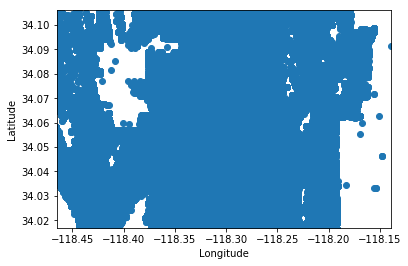

In [23]:
#plot of all crimes lat v lon
plt.scatter(df['LON'],df['LAT'])
plt.xlim([-118.465381,-118.138795])
plt.ylim([34.016907, 34.105999])
plt.ylabel('Latitude')
plt.xlabel('Longitude')

In [15]:
np.argmin(df['LON'])

C:\Users\Jacob\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


727420

In [ ]:
df['TIME OCC'].value_counts()[:10].plot(kind = 'bar')

f0 = plt.gcf()

In [ ]:
df['DATE OCC'].value_counts()[:10].plot(kind = 'bar')

f1 = plt.gcf()

In [ ]:
df['AREA NAME'].value_counts().plot(kind = 'bar')

f2 = plt.gcf()

In [ ]:
df['Vict Age'].value_counts()[:30].plot(kind = 'bar')

f3 = plt.gcf()

In [ ]:
df['Vict Descent'].value_counts().plot(kind = 'bar')

f4 = plt.gcf()

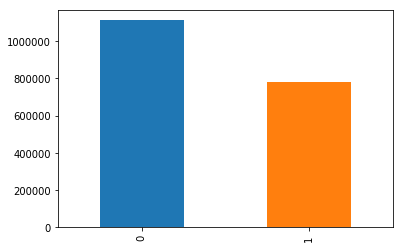

In [29]:
df['violent_crime'].value_counts().plot(kind = 'bar')

f5 = plt.gcf()

In [ ]:
df['Vict Descent'].unique()

What can we drop? (eg '0' ages, unknown descent) - new dataframes?, X,H,N genders
multi logistic regression
how to do knn
    formula = 'Vict Sex ~ TIME OCC + LAT + LON'
    age, descent too
    

In [ ]:
#plot geographical data, violent and non violent separated by color

#sklearn multiple logistic regression

    # pay equal attention class_weight = balanced
    

In [ ]:
df['Vict Sex'].value_counts().plot(kind = 'bar')

f4 = plt.gcf()
#plot which crimes affect which gender the most
#gender and violent v nonviolent crimes

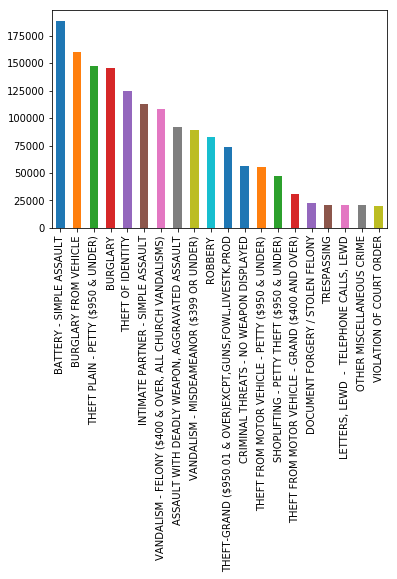

In [30]:
df['Crm Cd Desc'].value_counts()[:20].plot(kind = 'bar')

f4 = plt.gcf()

### Perform logistic regression to determine a relationship between time/location and the type of crime committed 
- predictors = latitude, longitude, time occurred
- response = violent crime (1)/non violent crime (0)


Text(0.5, 1.0, 'Time prediction')

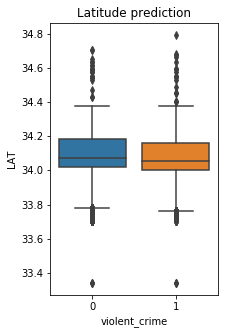

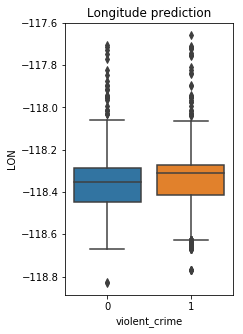

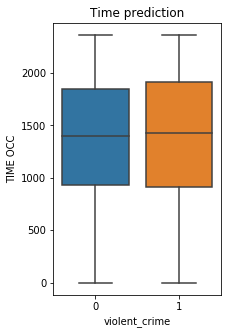

In [51]:
fig, ax = plt.subplots(figsize = (3,5))
lat_box = sns.boxplot(x = 'violent_crime', y = 'LAT', data = df, ax = ax)
lat_box.set_title('Latitude prediction')

fig, ax = plt.subplots(figsize = (3,5))
long_box = sns.boxplot(x = 'violent_crime', y = 'LON', data = df, ax = ax)
long_box.set_title('Longitude prediction')

fig, ax = plt.subplots(figsize = (3,5))
time_box = sns.boxplot(x = 'violent_crime', y = 'TIME OCC', data = df, ax = ax)
time_box.set_title('Time prediction')

In [58]:
results = smf.logit(formula = 'violent_crime ~ LAT', data = df).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.674121
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          violent_crime   No. Observations:              1888499
Model:                          Logit   Df Residuals:                  1888497
Method:                           MLE   Df Model:                            1
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                0.005189
Time:                        17:30:58   Log-Likelihood:            -1.2731e+06
converged:                       True   LL-Null:                   -1.2797e+06
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.1584      0.440    113.944      0.000      49.296      51.021
LAT           -1.4823      0.013   -114.746      0.000      -1.508      -1.457
==============================================================================
"""

In [65]:
#make predictions on violent crime with latitude

lat_test = pd.DataFrame()
lat_test['LAT'] = np.linspace(33.3427,34.7907,100)
lat_test['pred_violent'] = results.predict(lat_test)

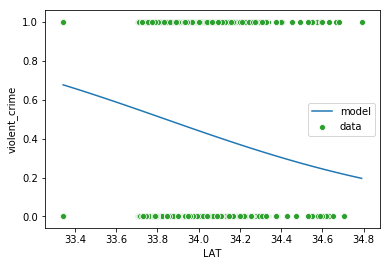

In [66]:
#plot
fig,ax = plt.subplots()

#model prediction
sns.lineplot(x = 'LAT', y = 'pred_violent', data = lat_test, ax = ax, label = 'model')
sns.scatterplot(x = 'LAT', y = 'violent_crime', data = df, ax = ax, color = 'C2',label = 'data')

In [69]:
#model predictions added to original data frame 
df['pred_violent'] = (results.predict() > 0.5).astype(int)

#confusion matrix
conf_mat = metrics.confusion_matrix(df['violent_crime'], df['pred_violent'])
conf_mat

array([[1065422,   44699],
       [ 748954,   29424]], dtype=int64)

In [71]:
def sensitivity(conf_mat):
    return conf_mat[1,1]/np.sum(conf_mat[1,:])
def specificity(conf_mat):
    return conf_mat[0,0]/np.sum(conf_mat[0,:])

In [72]:
sensitivity(conf_mat)

0.03780168504248579

In [73]:
specificity(conf_mat)

0.9597350198762117